# Stap 1: Data voorbereiden:
1. Zorg dat je een dataset hebt van ruim meer dan 1000 afbeeldingen
2. Splits de data in 3 datasets:

    a) x_train: ongeveer 80% van de gehele dataset
    
    b) x_test: ongeveer 20% van de gehele dataset
    
    c) x_val: ongeveer 5 afbeeldingen die geen anomally zijn (uit je dataset) + een aantal anomallies
<b> Belangrijk </b>, zorg er voor data je de data _random_ split

3. Zet de afbeeldingen om naar 28 x 28
4. Maak de afbeeldingen zwart wit
5. Maak van elke dataset een numpy object met de shape (aantal_afbeeldingen, 28, 28)

<b> Tip: </b> Kijk even of het is goedgegaan door door je datasets heen te bladeren en afbeeldingen met de "imshow" functie van matplotlib

6. Pixels hebben normaal een waarde tussen 0 en 255, het model werkt alleen met waarden tussen 0 en 1

In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import random as rd


In [22]:

images = []
new_images = []
subsample_images = []

for image_name in os.listdir("image_data/image_data"):
    if '.png' in image_name:
        print(f'image_name: {image_name}')
        image = cv2.imread(f'image_data/image_data/{image_name}', cv2.IMREAD_GRAYSCALE)
        image = Image.fromarray(image)
        image = np.array(image.resize((32, 32), Image.LANCZOS))
        images.append(image)

for image_name in os.listdir("Nieuwe plaatjes"):
    if '.png' in image_name:
        image = cv2.imread(f'Nieuwe plaatjes/{image_name}', cv2.IMREAD_GRAYSCALE)
        image = Image.fromarray(image)
        image = np.array(image.resize((32, 32), Image.LANCZOS))
        new_images.append(image)
        
for image_name in os.listdir("Subsample_image_data\Subsample_image_data"):
    if '.png' in image_name:
        image = cv2.imread(f'Subsample_image_data\Subsample_image_data/{image_name}', cv2.IMREAD_GRAYSCALE)
        image = Image.fromarray(image)
        image = np.array(image.resize((32, 32), Image.LANCZOS))
        subsample_images.append(image)
rd.shuffle(images)

images = np.stack(images)
new_images = np.stack(new_images)
new_images.shape

image_name: 00101_1_L.png
image_name: 00101_2_F.png
image_name: 00101_3_F.png
image_name: 00102_1_F.png
image_name: 00102_1_R.png
image_name: 00102_2_F.png
image_name: 00103_1_F.png
image_name: 00103_1_L.png
image_name: 00103_2_F.png
image_name: 00104_1_F.png
image_name: 00104_1_R.png
image_name: 00104_2_F.png
image_name: 00105_1_F.png
image_name: 00105_1_R.png
image_name: 00105_2_F.png
image_name: 00106_1_F.png
image_name: 00106_1_R.png
image_name: 00106_2_F.png
image_name: 00107_1_F.png
image_name: 00107_1_R.png
image_name: 00107_2_F.png
image_name: 00108_1_F.png
image_name: 00108_1_R.png
image_name: 00108_2_F.png
image_name: 00109_1_F.png
image_name: 00109_2_F.png
image_name: 00109_2_R.png
image_name: 00110_1_F.png
image_name: 00110_1_L.png
image_name: 00110_2_F.png
image_name: 00111_1_F.png
image_name: 00111_2_F.png
image_name: 00111_2_L.png
image_name: 00112_1_F.png
image_name: 00112_1_L.png
image_name: 00112_2_F.png
image_name: 00113_1_F.png
image_name: 00113_1_R.png
image_name: 

(5, 32, 32)

In [23]:
n_images = len(images)
random_list = rd.sample(range(1001), 5)


n_train = int(n_images * 0.8)
n_test = n_images - n_train

indices = np.arange(n_images)
np.random.shuffle(indices)

train_indices = indices[:n_train]
test_indices = indices[n_train:]

x_val = np.concatenate((images[random_list], new_images), axis=0)
#x_val = np.concatenate((subsample_images, new_images), axis=0)
x_train = images[train_indices]
x_test = images[test_indices]
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32') / 255.0
x_val  = x_val.astype('float32') / 255.0

# Stap 2: Het trainen van de Autoencoder
Hieronder krijgen jullie de code van het model (de autoencoder), hij is opgesschreven als functie. In de documentatie van de functie staat wat de inputs en outputs zijn.

In [24]:
def train_autoencoder(x_train, x_test, latent_dim=16, num_epochs=50):
    """
    32x32 Autoencoder - happy medium tussen sterke manifold forcing en reguliere autoencoder
    - Encoder: conv layers + lichte Dense bottleneck
    - Decoder: conv transpose layers
    - Loss: MeanSquaredError
    """
    import tensorflow as tf
    from tensorflow.keras import layers, losses, Model

    input_shape = x_train.shape[1:]  # (32,32)

    # --- Encoder ---
    encoder_input = layers.Input(shape=input_shape)
    x = layers.Reshape((32,32,1))(encoder_input)

    x = layers.Conv2D(32, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.MaxPooling2D((2,2), padding='same')(x)  # 32 -> 16

    x = layers.Conv2D(64, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.MaxPooling2D((2,2), padding='same')(x)  # 16 -> 8

    # Lichte Dense bottleneck
    x = layers.Flatten()(x)
    latent = layers.Dense(latent_dim, activation='tanh')(x)
    x = layers.Dense(8*8*64, activation='relu')(latent)
    x = layers.Reshape((8,8,64))(x)

    # --- Decoder ---
    x = layers.Conv2DTranspose(64, (3,3), strides=2, padding='same')(x)  # 8 -> 16
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)

    x = layers.Conv2DTranspose(32, (3,3), strides=2, padding='same')(x)  # 16 -> 32
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)

    decoder_output = layers.Conv2D(1, (3,3), padding='same', activation='sigmoid')(x)
    decoder_output = layers.Reshape((32,32))(decoder_output)

    autoencoder = Model(encoder_input, decoder_output, name='cnn_autoencoder')
    autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

    history = autoencoder.fit(
        x_train, x_train,
        epochs=num_epochs,
        shuffle=True,
        validation_data=(x_test, x_test)
    )

    return autoencoder, history.history['loss'], history.history['val_loss']



## 2.1 Trainen
Train het model met de functie hierboven, kies een lage waarde voor de epochs


In [26]:
model, loss_train, loss_test = train_autoencoder(x_train, x_test, 64, 50)

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0421 - val_loss: 0.0755
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0255 - val_loss: 0.0726
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0229 - val_loss: 0.0711
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0209 - val_loss: 0.0729
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0193 - val_loss: 0.0692
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0189 - val_loss: 0.0664
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0183 - val_loss: 0.0611
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0174 - val_loss: 0.0572
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0174 - val_loss: 0.0513
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0166 - val_loss: 0.0524
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0162 - val_loss: 0.0380
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0

## 2.2 Analyseer de loss functie:
Plot de loss functie en bepaal of je het model lang genoeg getrained hebt

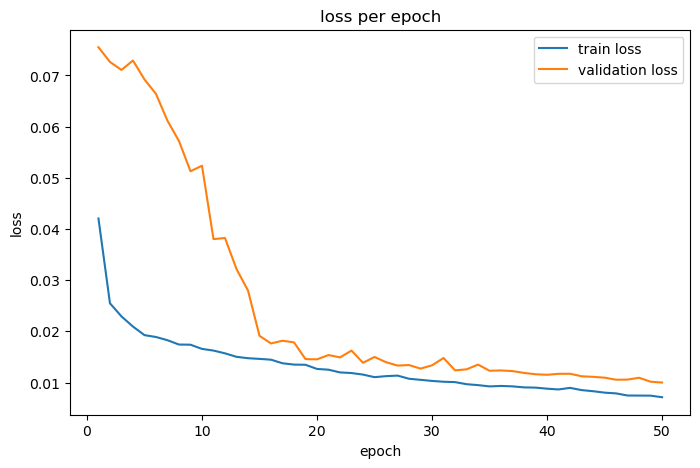

In [27]:
epochs = range(1, len(loss_train)+1)  # x-as: epoch nummer

plt.figure(figsize=(8,5))
plt.plot(epochs, loss_train, label='train loss')
plt.plot(epochs, loss_test, label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss per epoch')
plt.legend()
plt.show()

# Stap 3: Predictions
Gebruik de predict method van het model en stop hier je x_val dataset in.
Plot de originele en gereconstrueerde afbeeldingen en vergelijk ze, zie je verschil met de outliers?

In [28]:
reconstructed = model.predict(x_val)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


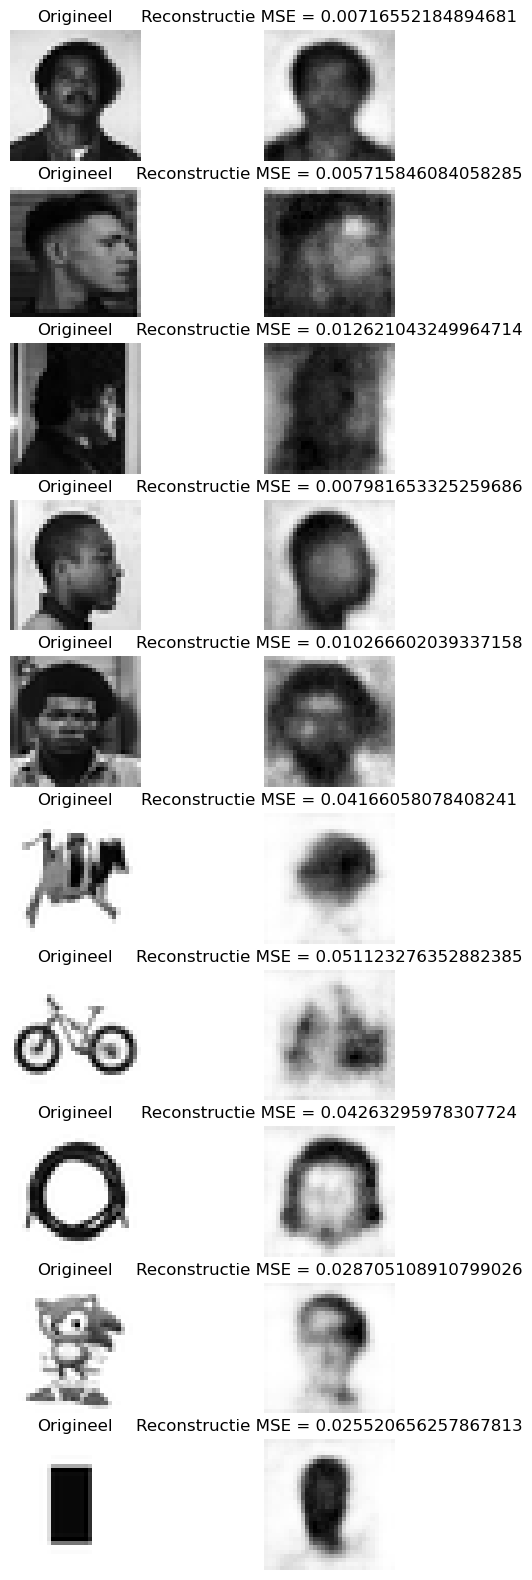

In [29]:
mse_list = np.array([
    mean_squared_error(x_val[i].flatten(), reconstructed[i].flatten())
    for i in range(len(x_val))
])
n = x_val.shape[0]
fig, ax = plt.subplots(n, 2, figsize=(6, n*2))

for i in range(n):
    # Origineel
    ax[i, 0].imshow(x_val[i], cmap='gray')
    ax[i, 0].set_title("Origineel")
    ax[i, 0].axis("off")

    # Reconstructie
    ax[i, 1].imshow(reconstructed[i], cmap='gray')
    ax[i, 1].set_title(f"Reconstructie MSE = {mse_list[i]}")
    ax[i, 1].axis("off")

# Stap 4: Outlier detection
## 4.1 Quanitificeer de verschillen
Vergelijk de verschillen in de afbeeldingen met verschillende performance metrics zoals MSE, RMSE, MAPE, 
gebruik hiervoor de module <b> sklearn.metrics

Kies eerst MSE om te kijken of er een significant verschill is met outliers en niet-outliers

# 4.2 Tunen
Kan je alle outliers eruit halen op basis van de metrics? Gefeliciteerd
Mocht dit niet het geval zijn, dan kan dit aan de "latent_dim" liggen, de ruimte naar waar de afbeelding wordt samengeknepen in het model, speel met deze parameter en kijk of het de verschillen tussen de outliers en niet-outliers kan verbeteren.

## 4.3 Threshold
Als de vorige stappen goed werken wordt het tijd om automatisch aan te geven wat de outliers zijn.
Kies een threshold voor de door jouw gekozen performance metric.

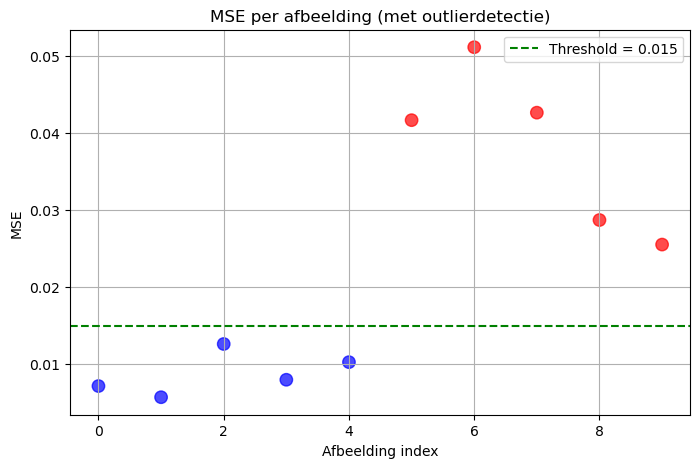

Outlier indices: [5, 6, 7, 8, 9]


In [30]:
# --- 2️⃣ Stel je drempel in ---
threshold = 0.015

# --- 3️⃣ Bepaal welke indices outliers zijn ---
outlier_indices = np.where(mse_list > threshold)[0]

# --- 4️⃣ Maak kleurenlijst voor plot ---
colors = ['red' if i in outlier_indices else 'blue' for i in range(len(mse_list))]

# --- 5️⃣ Plot MSE-waarden ---
plt.figure(figsize=(8,5))
plt.scatter(range(len(mse_list)), mse_list, c=colors, s=80, alpha=0.7)
plt.axhline(y=threshold, color='green', linestyle='--', label=f"Threshold = {threshold}")
plt.title("MSE per afbeelding (met outlierdetectie)")
plt.xlabel("Afbeelding index")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.show()

# --- 6️⃣ Toon de indices van outliers ---
print("Outlier indices:", outlier_indices.tolist())


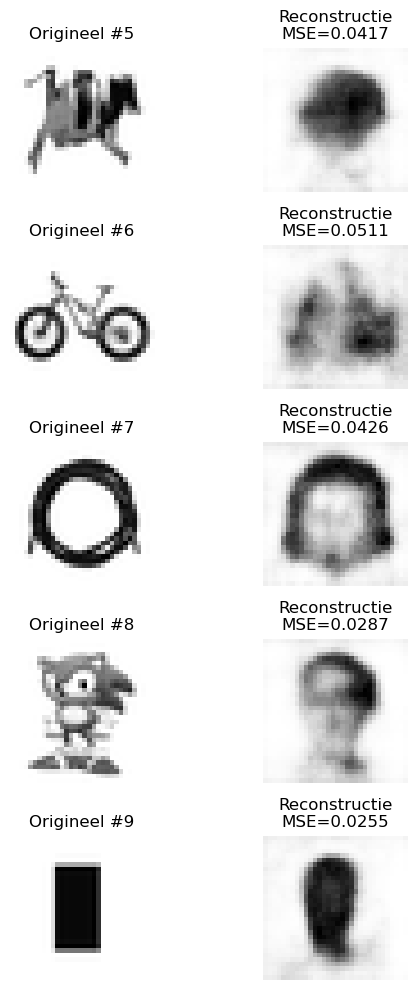

In [31]:

# Controleer dat er outliers zijn gevonden
if len(outlier_indices) == 0:
    print("Er zijn geen outliers gevonden.")
else:
    n = len(outlier_indices)
    fig, ax = plt.subplots(n, 2, figsize=(6, 2*n))

    for i, idx in enumerate(outlier_indices):
        # Origineel
        ax[i, 0].imshow(x_val[idx], cmap='gray')
        ax[i, 0].set_title(f"Origineel #{idx}")
        ax[i, 0].axis("off")

        # Reconstructie
        ax[i, 1].imshow(reconstructed[idx], cmap='gray')
        ax[i, 1].set_title(f"Reconstructie\nMSE={mse_list[idx]:.4f}")
        ax[i, 1].axis("off")

    plt.tight_layout()
    plt.show()

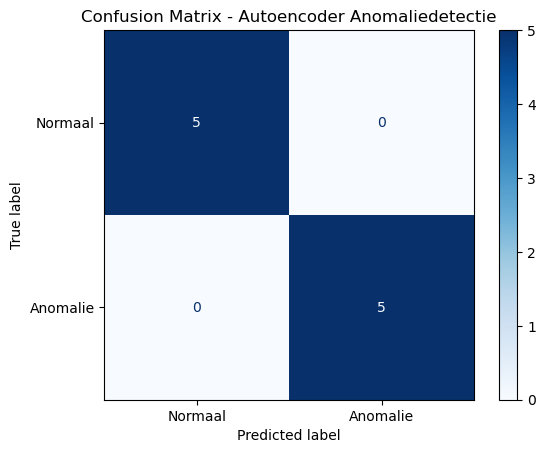

True Positives (TP): 5  → correct als anomalie herkend
False Positives (FP): 0 → foutief als anomalie herkend (normaal plaatje)
False Negatives (FN): 0 → anomalie niet herkend
True Negatives (TN): 5  → correct als normaal herkend


In [32]:
## Stap 5: Confusion matrix van de autoencoder

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --- 1️⃣ Bepaal ground truth labels ---
# 0 = normaal, 1 = anomalie
true_labels = np.array([0] * len(random_list) + [1] * len(new_images))
#true_labels = np.array([0] * len(subsample_images) + [1] * len(new_images))
# --- 2️⃣ Maak voorspellingen obv je threshold ---
predicted_labels = (mse_list > threshold).astype(int)

# --- 3️⃣ Bereken de confusion matrix ---
cm = confusion_matrix(true_labels, predicted_labels)

# --- 4️⃣ Visualiseer de matrix ---
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normaal", "Anomalie"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Autoencoder Anomaliedetectie")
plt.show()

# --- 5️⃣ Print interpretatie ---
tn, fp, fn, tp = cm.ravel()
print(f"True Positives (TP): {tp}  → correct als anomalie herkend")
print(f"False Positives (FP): {fp} → foutief als anomalie herkend (normaal plaatje)")
print(f"False Negatives (FN): {fn} → anomalie niet herkend")
print(f"True Negatives (TN): {tn}  → correct als normaal herkend")


# Opdracht voor volgende week
Maak een algoritme dat automatisch verteld of een afbeelding een anomally is op basis van jouw model.

Deel daarnaast mogelijke interessante bevindingen.

Iedereen mag even kort voor de groep presenteren